In [10]:
import sys
import os
from pathlib import Path
import numpy as np

# Get the directory of the current script
script_dir = Path(os.getcwd()).resolve()

# Add the src directory to the Python path
sys.path.append(str(Path(script_dir / '../src').resolve()))

figure_dir = '../data/processed/plots/manual/'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [11]:
import numpy as np
from utils import convert_units
from model import model

units = np.random.choice(list(convert_units.keys())) # This chooses a random energy scale among [MeV, GeV, TeV]

# This selects a pair of couplings for which we expect a first-order phase transition over large intervals of vevs
lambda_ = 1.5e-3
g = 0.5
vev = np.random.uniform(0, 1e3) # This chooses a random vev between [0, 1e3] in the selected units
description = "Fast"

# Alternatively, these are the bechmark points presented in arXiv:2501.15649 [hep-ph]
lambda_, g, vev, units, description  = 6e-3, 0.74988, 500, "MeV", "Slow" # BP1
#lambda_, g, vev, units, description  = 6e-3, 0.7498251216179918 * 0.99999, 1000, "MeV", "BP2"
#lambda_, g, vev, units, description  = 6e-3, 0.7497236810049601 * 0.99999, 3, "GeV", "BP3" 
#lambda_, g, vev, units, description  = 1e-2, 0.8541240569516538, 1, "GeV", "BP4" 

# This constructs the finite-temperature potential as an instance of the class model. 
dp = model(vev, lambda_, g, xstep= vev * 1e-3, Tstep=vev * 1e-3)
V = dp.DVtot # This is the scalar potential shifted such that the false vacuum is located at ϕ = 0 for each value of the temperature
dV = dp.gradV # This is the gradient of the scalar potential

print(f"lambda = {lambda_}")
print(f"g = {g}")
print(f"vev = {vev} {units}")

lambda = 0.006
g = 0.74988
vev = 500 MeV


In [12]:
from temperatures import find_T_min, find_T_max, refine_Tmin

T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(V, dV, precision= 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, tmax=2.5 * vev)
T_min, vevs_min, false_min_tmin = find_T_min(V, dV, tmax=T_max, precision = 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, max_min_vals = max_min_vals)

if T_max is not None and T_min is not None:
    maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
elif T_max is not None:
    maxvev = np.max(vevs_max)
elif T_min is not None:
    maxvev = np.max(vevs_min)
else:
    maxvev = None

T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision = 6) if T_min is not None else None

print(f"T_max = {T_max:.6e} {units}")
print(f"T_min = {T_min:.6e} {units}")

T_max = 1.157500e+02 MeV
T_min = 0.000000e+00 MeV


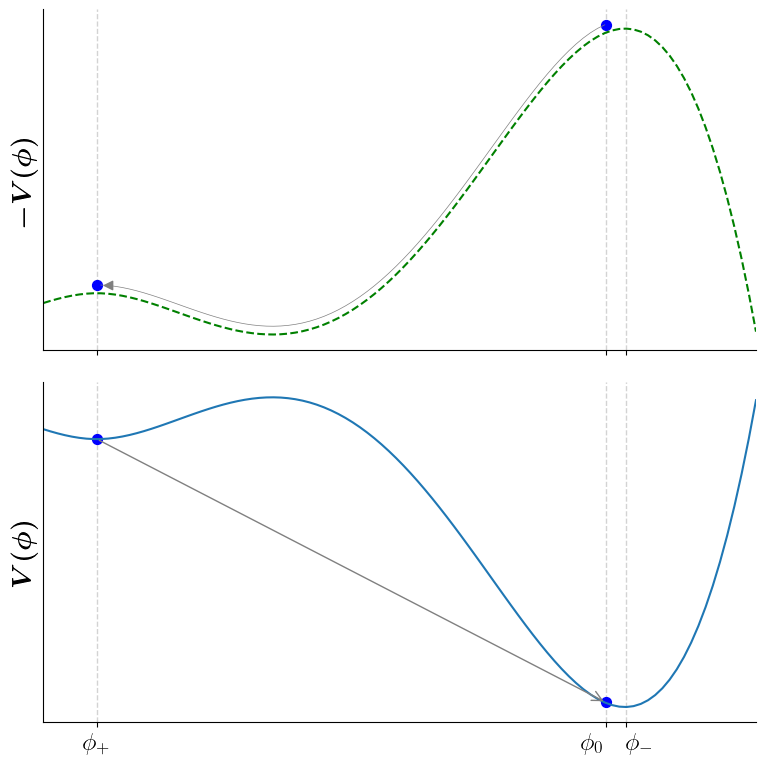

In [ ]:
from espinosa import Vt_vec

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,              # Base font size
    'axes.titlesize': 20,         # Title font size
    'axes.labelsize': 20,         # Label font size
    'axes.labelweight': 'bold',   # Make axis labels bold
    'xtick.labelsize': 18,        # X-tick label size
    'ytick.labelsize': 18,        # Y-tick label size
    'legend.fontsize': 18,        # Legend font size
    'figure.titlesize': 20,        # Figure title size
    'text.usetex': True,          # Use LaTeX for all text rendering
    'text.latex.preamble': r'\usepackage{amsmath,amssymb,bm}'
})

phi = np.linspace(-0.1 * vev, 1.23 * vev, 100)
phi = phi.reshape(-1,1)
t = 90
v = V(phi, t)

inst = Vt_vec(t, V, dV, step_phi = 1e-3, precision = 1e-4, vev0 = maxvev, int_threshold = 2e-1, ratio_vev_step0 = 1000, save_all = True)

# Create figure with two vertically stacked subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Plot -V on top subplot
ax1.plot(phi, -v, label="-V", linestyle='--', color='green')
mask_roll = (phi.flatten() >= 0) & (phi.flatten() <= inst.phi0_min)
delta_roll = 0.2
ax1.plot(phi.flatten()[mask_roll], -v[mask_roll] + delta_roll * np.max(v), linestyle='-', color='gray', linewidth=0.5)

# Add circles at the first and last elements of the masked line
first_point = (0, (-v[mask_roll] + delta_roll * np.max(v))[0])
last_point = (inst.phi0_min, (-v[mask_roll] + delta_roll * np.max(v))[-1])
ax1.scatter(*first_point, color='blue', s=50)
ax1.scatter(*last_point, color='blue', s=50)
# Use marker parameter instead of shape
ax1.scatter(phi.flatten()[mask_roll][1], -v[mask_roll][1] + delta_roll * np.max(v), marker='<', color='gray')

ax1.axvline(0, color='lightgrey', linestyle='--', linewidth=1, zorder=0)
ax1.axvline(inst.phi0_min, color='lightgrey', linestyle='--', linewidth=1, zorder=0)
ax1.axvline(phi[np.argmin(v)][0], color='lightgrey', linestyle='--', linewidth=1, zorder=0)
ax1.set_ylabel(r"$\boldsymbol{-V(\phi)}$")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

# Plot V on bottom subplot
ax2.plot(phi, v, label="V")
ax2.axvline(0, color='lightgrey', linestyle='--', linewidth=1, zorder=0)
ax2.axvline(inst.phi0_min, color='lightgrey', linestyle='--', linewidth=1, zorder=0)
ax2.axvline(phi[np.argmin(v)][0], color='lightgrey', linestyle='--', linewidth=1, zorder=0)

# Add an arrow from (0, v[phi==0]) to (inst.phi0_min, v[inst.phi0_min])
start_x = 0
start_y = v[np.argmin(np.abs(phi.flatten()))]
end_x = inst.phi0_min
end_y = v[np.argmin(np.abs(phi.flatten() - inst.phi0_min))]
ax2.annotate(
    '', 
    xy=(end_x, end_y), 
    xytext=(start_x, start_y), 
    arrowprops=dict(color='gray', arrowstyle='->', lw=1.0)
)
ax2.scatter(start_x, start_y, color='blue', s=50)
ax2.scatter(end_x, end_y, color='blue', s=50)

# Add x-axis labels (\phi_+, \phi_0, \phi_-)
phi_plus = 0
phi_0 = inst.phi0_min
phi_minus = phi[np.argmin(v)][0]
ax2.set_xticks([phi_plus, phi_0, phi_minus])
#ax2.set_xticklabels([r"$\phi_+$", r"$\phi_0$", r"$\phi_-$"])

# Remove the original tick labels
ax2.set_xticklabels([])

y_label_pos = 1.03*np.min(v)
# Add custom labels as annotations for precise positioning
ax2.annotate(r"$\phi_+$", (phi_plus, y_label_pos), xytext=(0, -20), textcoords='offset points',
             ha='center', va='center', fontsize=18)
ax2.annotate(r"$\phi_0$", (phi_0, y_label_pos), xytext=(-10, -20), textcoords='offset points',
             ha='center', va='center', fontsize=18)
ax2.annotate(r"$\phi_-$", (phi_minus, y_label_pos), xytext=(10, -20), textcoords='offset points',
             ha='center', va='center', fontsize=18)

#ax2.set_xlabel(r"$\phi$")
ax2.set_ylabel(r"$\boldsymbol{V(\phi)}$")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.set_xticks([])
ax2.set_yticks([])

# Set x limits for both plots
ax2.set_xlim(phi[0], phi[-1])

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(figure_dir + "bounce.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Extract keys and values from the dictionary
keys = list(inst.all_sums.keys())
values = [inst.all_sums[key] for key in keys]

# Sort both keys and values based on the keys in ascending order
sorted_pairs = sorted(zip(keys, values), key=lambda pair: pair[0])
sorted_phi0, sorted_sums = zip(*sorted_pairs)
sorted_phi0, sorted_sums = np.array(sorted_phi0), np.array(sorted_sums)

# Extract keys and values from the dictionary
keys = list(inst.all_vt4.keys())
values = [inst.all_vt4[key] for key in keys]

# Sort both keys and values based on the keys in ascending order
sorted_pairs = sorted(zip(keys, values), key=lambda pair: pair[0])
sorted_phi0, sorted_vt4 = zip(*sorted_pairs)
sorted_phi0, sorted_vt4 = np.array(sorted_phi0), np.array(sorted_vt4)


# Create a mask for monotonically decreasing arrays
monotonic_mask = []

for arr in sorted_vt4:
    # Check if the array is array-like
    if hasattr(arr, '__len__') and not isinstance(arr, str):
        # If array has 0 or 1 element, consider it monotonically decreasing
        if len(arr) <= 1:
            monotonic_mask.append(True)
        else:
            # Check if each element is less than or equal to the previous one
            is_monotonic = np.all(arr[1:] <= arr[:-1])
            monotonic_mask.append(is_monotonic)
    else:
        # Scalar values are considered monotonically decreasing
        monotonic_mask.append(True)

# Convert to numpy array
monotonic_mask = np.array(monotonic_mask)

/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_55084/2827343327.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


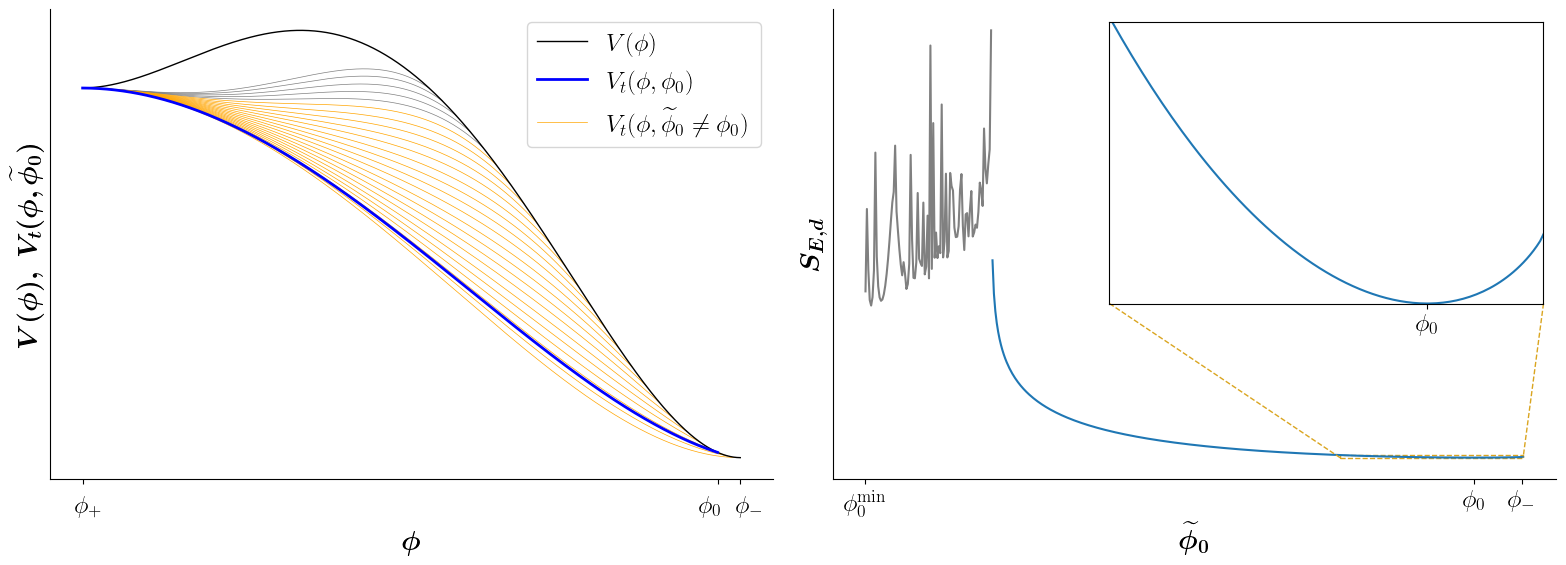

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- First plot (left side) ---
plt.sca(ax1)  # Set current axes to the first subplot

# Define the fraction of indices to plot
fraction = 0.05

# Get the total number of indices
num_indices = len(inst.all_vt4.keys())

# Calculate the number of indices to select
num_to_select = max(2, int(num_indices * fraction))  # Ensure at least 2 indices (first and last)

sample = np.linspace(sorted_phi0[0], sorted_phi0[-1], num_to_select)
# Initialize an array to store indices of closest elements
closest_indices = []
mask_left = np.zeros(len(sorted_phi0), dtype=bool)

# For each value in sample, find the closest value in sorted_keys
for value in sample:
    # Calculate absolute differences between current value and all elements in sorted_keys
    differences = np.abs(sorted_phi0 - value)
    
    # Find the index of minimum difference (closest element)
    closest_idx = np.argmin(differences)
    closest_indices.append(closest_idx)
    
    # Set the mask to True for this index
    mask_left[closest_idx] = True

# Plot for the selected indices
printlabel = True
for idx in range(len(sorted_phi0[mask_left])):
    mask_temp = inst.phi <= sorted_phi0[mask_left][idx]
    
    # Check if current phi0 value is in the monotonically decreasing set
    if sorted_phi0[mask_left][idx] in sorted_phi0[monotonic_mask]:
        line_color = 'orange'  # Keep orange for monotonically decreasing
        if printlabel:
            label = r'$V_t(\phi, \widetilde{\phi}_0 \neq \phi_0)$'
            printlabel = False
        else:
            label = None
    else:
        line_color = 'gray'    # Use gray otherwise
        label = None
        
    temp = ax1.plot(inst.phi[mask_temp], sorted_vt4[mask_left][idx][mask_temp], linewidth=0.5, color=line_color, label=label)
    if label is not None:
        orange_line = temp[0]

V_line = ax1.plot(inst.phi, inst.V, linewidth=1, color='black', label='$V(\phi)$')[0]
idx = np.where(inst.phi0_old == inst.phi0_min)[0][0]
mask_v0 = inst.phi <= inst.phi0_min
Vt_line = ax1.plot(inst.phi[mask_v0], inst.vt4[idx][mask_v0], linewidth=2, color='blue', label='$V_t(\phi, \phi_0)$')[0]

# Remove all labels and ticks
ax1.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, left=False, bottom=False)

# Add specific ticks to the x-axis
ax1.set_xticks([inst.phi[0], inst.phi0_min, inst.vevT])
#ax1.set_xticklabels(['$\\phi_+$', '$\\phi_0$', '$\\phi_-$'])
ax1.tick_params(axis='x', which='both', bottom=True, labelbottom=True)

#ax1.set_xlabel(r"$\phi$")
ax1.set_ylabel(r"$\boldsymbol{V(\phi),\ V_t(\phi, \widetilde{\phi}_0)}$")
ax1.set_xlabel(r"$\boldsymbol{\phi}$", labelpad=30)

# Remove the upper and right axes
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Remove the original tick labels
ax1.set_xticklabels([])

y_label_pos = 1.055*np.min(v)
# Add custom labels as annotations for precise positioning
ax1.annotate(r"$\phi_+$", (phi_plus + 0.01 * phi_minus, y_label_pos), xytext=(0, -20), textcoords='offset points',
             ha='center', va='center', fontsize=18)
ax1.annotate(r"$\phi_0$", (1.01 * phi_0, y_label_pos), xytext=(-10, -20), textcoords='offset points',
             ha='center', va='center', fontsize=18)
ax1.annotate(r"$\phi_-$", (0.99 * phi_minus, y_label_pos), xytext=(10, -20), textcoords='offset points',
             ha='center', va='center', fontsize=18)

# Create legend with custom order
legend_handles = [V_line, Vt_line, orange_line]
legend_labels = [r'$V(\phi)$', r'$V_t(\phi, \phi_0)$', r'$V_t(\phi, \widetilde{\phi}_0 \neq \phi_0)$']
ax1.legend(legend_handles, legend_labels)

# --- Second plot (right side) ---
# Define limits for the zoomed region
lower_limit = 0.9 * inst.phi0_min
upper_limit = np.min([1.1 * inst.phi0_min, sorted_phi0.max()])

mask_right = (sorted_phi0 >= lower_limit) & (sorted_phi0 <= upper_limit)

# Plot the main figure
ax2.plot(sorted_phi0[~monotonic_mask], sorted_sums[~monotonic_mask], color='gray')
ax2.plot(sorted_phi0[monotonic_mask], sorted_sums[monotonic_mask])
ax2.set_yscale('log')

# Remove all labels and ticks on the main figure
ax2.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, left=False, bottom=False)

# Remove the upper and right axes of the main figure
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Create an inset plot
ax_inset = inset_axes(ax2, width="60%", height="60%", loc='upper right')
ax_inset.plot(sorted_phi0[mask_right], sorted_sums[mask_right])
ax_inset.set_yscale('log')

# Adjust the inset plot limits to match the zoomed region
ax_inset.set_xlim(lower_limit, upper_limit)
ax_inset.set_ylim(sorted_sums[mask_right].min(), sorted_sums[mask_right].max())

# Remove all labels and ticks on the inset plot, but keep the frame
ax_inset.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, left=False, bottom=False)

# Connect the inset with the main plot using indicate_inset_zoom
mark_inset(ax2, ax_inset, loc1=3, loc2=4, fc="none", ec="goldenrod", lw=1, ls='--')

# Add specific ticks to the x-axis of the outer plot
ax2.set_xticks([sorted_phi0[0], inst.phi0_min, inst.vevT])
ax2.set_xticklabels(['$\\phi_0^\mathrm{min}$', '$\\phi_0$', '$\\phi_-$'])
ax2.tick_params(axis='x', which='both', bottom=True, labelbottom=True)

# Add a specific tick to the x-axis of the inner plot
ax_inset.set_xticks([inst.phi0_min])
ax_inset.set_xticklabels(['$\\phi_0$'])
ax_inset.tick_params(axis='x', which='both', bottom=True, labelbottom=True)

# Add y-axis label to the external plot only
ax2.set_ylabel(r'$\boldsymbol{S_{E,d}}$')
ax2.set_xlabel(r'$\boldsymbol{\widetilde{\phi}_0}$')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(figure_dir + "tunnelling.pdf", dpi=300, bbox_inches='tight')

# Show the combined figure
plt.show()

In [16]:
# This constructs the finite-temperature potential as an instance of the class model. 
vev_fast = 500
lambda_fast = 1.5e-3
g_fast = 0.5

dp_fast = model(vev_fast, lambda_fast, g_fast, xstep= vev * 1e-3, Tstep=vev * 1e-3)
V_fast = dp_fast.DVtot # This is the scalar potential shifted such that the false vacuum is located at ϕ = 0 for each value of the temperature
dV_fast = dp_fast.gradV # This is the gradient of the scalar potential

In [17]:
from temperatures import find_T_min, find_T_max, refine_Tmin

T_max_fast, vevs_max_fast, max_min_vals_fast, false_min_tmax_fast = find_T_max(V_fast, dV_fast, precision= 1e-2, Phimax = 2 * vev_fast, step_phi = vev_fast * 1e-2, tmax=2.5 * vev_fast)
T_min_fast, vevs_min_fast, false_min_tmin_fast = find_T_min(V_fast, dV_fast, tmax=T_max_fast, precision = 1e-2, Phimax = 2 * vev_fast, step_phi = vev_fast * 1e-2, max_min_vals = max_min_vals_fast)

if T_max_fast is not None and T_min_fast is not None:
    maxvev_fast = np.max(np.concatenate((vevs_max_fast, vevs_min_fast)))
elif T_max_fast is not None:
    maxvev_fast = np.max(vevs_max_fast)
elif T_min is not None:
    maxvev_fast = np.max(vevs_min_fast)
else:
    maxvev_fast = None

T_min_fast = refine_Tmin(T_min_fast, V_fast, dV_fast, maxvev_fast, log_10_precision = 6) if T_min_fast is not None else None

print(f"T_max = {T_max_fast:.6e} {units}")
print(f"T_min = {T_min_fast:.6e} {units}")

T_max = 8.850000e+01 MeV
T_min = 3.707910e+01 MeV


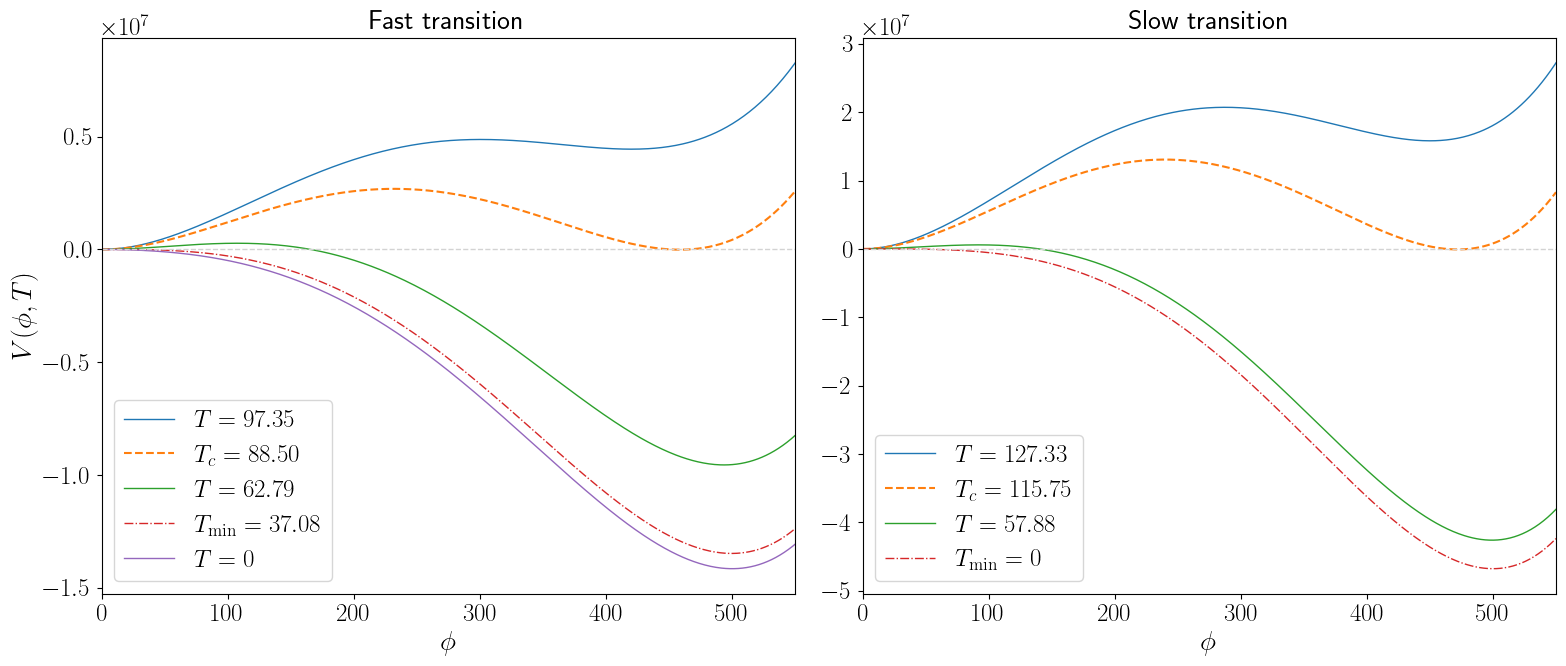

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# # Set global font size parameters (keep the same as in your figures.ipynb)
# plt.rcParams.update({
#     'font.size': 18,              # Base font size
#     'axes.titlesize': 16,         # Title font size
#     'axes.labelsize': 20,         # Label font size
#     'axes.labelweight': 'bold',   # Make axis labels bold
#     'xtick.labelsize': 18,        # X-tick label size
#     'ytick.labelsize': 18,        # Y-tick label size
#     'legend.fontsize': 18,        # Legend font size
#     'figure.titlesize': 16,        # Figure title size
#     'text.usetex': True,          # Use LaTeX for all text rendering
#     'text.latex.preamble': r'\usepackage{amsmath}'  # Use AMS math for LaTeX
# })

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# First plot (Fast transition) - left subplot
phi_fast = np.linspace(0, 1.1 * vev_fast, 500)
phi_fast = phi_fast.reshape(-1, 1)

t_high = 1.1 * T_max_fast
t_med = np.mean([T_max_fast, T_min_fast])

# Plot on the first axis
ax1.plot(phi_fast, V_fast(phi_fast, t_high), label=rf"$T = {t_high:.2f}$", linewidth=1)
ax1.plot(phi_fast, V_fast(phi_fast, T_max_fast), label=rf"$T_c = {T_max_fast:.2f}$", linestyle='--')
ax1.plot(phi_fast, V_fast(phi_fast, t_med), label=rf"$T = {t_med:.2f}$", linewidth=1)
ax1.plot(phi_fast, V_fast(phi_fast, T_min_fast), label=rf"$T_\mathrm{{min}} = {T_min_fast:.2f}$", linestyle='-.', linewidth=1)
ax1.plot(phi_fast, V_fast(phi_fast, 0), label=rf"$T = 0$", linewidth=1)

ax1.axhline(false_min_tmax_fast[1], color='lightgrey', linestyle='--', linewidth=1)
ax1.set_xlabel(r"$\phi$")
ax1.set_ylabel(r"$V(\phi, T)$")
ax1.set_xlim(phi_fast[0], phi_fast[-1])
ax1.legend()

# Set scientific notation for the y-axis of first plot
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax1.set_title("Fast transition")

# Second plot (Supercooled transition) - right subplot
t_high = 1.1 * T_max
t_med = np.mean([T_max, T_min])

# Plot on the second axis
ax2.plot(phi_fast, V(phi_fast, t_high), label=rf"$T = {t_high:.2f}$", linewidth=1)
ax2.plot(phi_fast, V(phi_fast, T_max), label=rf"$T_c = {T_max:.2f}$", linestyle='--')
ax2.plot(phi_fast, V(phi_fast, t_med), label=rf"$T = {t_med:.2f}$", linewidth=1)
ax2.plot(phi_fast, V(phi_fast, T_min), label=rf"$T_\mathrm{{min}} = {T_min:.0f}$", linestyle='-.', linewidth=1)
#ax2.plot(phi_fast, V(phi_fast, 0), label=rf"$T = 0$", linewidth=1)  # Commented out as in your original code

ax2.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1)
ax2.set_xlabel(r"$\phi$")
#ax2.set_ylabel(r"$V(\phi, T)$")
ax2.set_xlim(phi_fast[0], phi_fast[-1])
ax2.legend()

# Set scientific notation for the y-axis of second plot
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax2.set_title("Slow transition")

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure if needed
# plt.savefig("combined_transitions.pdf", dpi=300, bbox_inches='tight')

# Show the combined figure
plt.savefig(figure_dir + "critical_temperatures.pdf", dpi=300, bbox_inches='tight')
plt.show()